# pycaret install


In [ ]:
# 최적의 모델을 선정하기 위해 여러 모델을 한번에 학습하여 비교해주는 라이브러리 pycaret 설치
!pip install pycaret
from pycaret.classification import *

# 한글 깨짐 현상 (반영안되면 런타임 초기화 해주세요)


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family = 'NanumBarunGothic')

# 데이터 불러오기와 다듬기

In [ ]:
import pandas as pd

raw_hitters = pd.read_csv('2015~2022 hitters.csv', encoding = 'utf-8')
raw_pitchers = pd.read_csv('2015~2022 pitchers.csv')

print(raw_hitters.columns,'\n',raw_pitchers.columns)

Index(['순', '이름', '팀', 'WAR*', 'G', '타석', '타수', '득점', '안타', '2타', '3타', '홈런',
       '루타', '타점', '도루', '도실', '볼넷', '사구', '고4', '삼진', '병살', '희타', '희비', '타율',
       '출루', '장타', 'OPS', 'wOBA', 'wRC+', 'WAR*.1', 'WPA'],
      dtype='object') 
 Index(['순', '이름', '팀', 'WAR', '출장', '완투', '완봉', '선발', '승', '패', '세', '홀드',
       '이닝', '실점', '자책', '타자', '안타', '2타', '3타', '홈런', '볼넷', '고4', '사구', '삼진',
       '보크', '폭투', 'ERA', 'FIP', 'WHIP', 'ERA+', 'FIP+', 'WAR(need to drop)',
       'WPA'],
      dtype='object')


In [ ]:
# 필요없는 feature 삭제
raw_hitters.drop(['순','WAR*.1'], axis = 1, inplace = True)
raw_pitchers.drop(['순','WAR(need to drop)'], axis = 1, inplace = True)

In [ ]:
# 타자 데이터의 결합된 소속팀, 연도, 포지션 데이터 분리
hitters_team = raw_hitters.팀

team,year,position = [],[],[]

for x in hitters_team:
  if len(x) < 4:
    x = x + 'XX'
  y = str(20) + x[0:2]
  t = x[2]
  p = x[3:]

  year.append(y)
  team.append(t)
  position.append(p)

raw_hitters['소속팀'] = team
raw_hitters['연도'] = year
raw_hitters['포지션'] = position

raw_hitters.drop('팀', axis = 1, inplace = True)

hit_col=raw_hitters.columns

In [ ]:
# 투수 데이터의 결합된 소속팀, 연도, 포지션 데이터 분리

pitchers_team = raw_pitchers.팀

team,year = [],[]

for x in pitchers_team:
  y = str(20) + x[0:2]
  t = x[2]

  year.append(y)
  team.append(t)

raw_pitchers['소속팀'] = team
raw_pitchers['연도'] = year

raw_pitchers.drop('팀', axis = 1, inplace = True)

pit_col = raw_pitchers.columns

# 연봉 데이터 가져와서 붙이기

In [ ]:
# 여러 csv에서 dataframe을 가져와 concat
salary = pd.DataFrame()
for year in range(2016, 2024):
  temp = pd.read_csv(str(year) +' salary.csv')
  salary = pd.concat([salary, temp])

In [ ]:
# 팀 이름이 바뀐 경우 처리
salary.rename(columns = {'팀':'소속팀'}, inplace=True)
salary.rename(columns = {'선수':'이름'}, inplace=True)

salary.loc[salary['소속팀'] == '넥센', '소속팀'] = '키움'
salary.loc[salary['소속팀'] == 'SK', '소속팀'] = 'SSG'
salary['연도'] = salary['연도'].apply(str)
salary.sort_values(by = ["연도", '이름'], ascending = True, inplace = True)
salary.reset_index(drop = True, inplace = True)
salary['연봉']= salary['연봉'].str.replace(pat=r'[^\w]', repl=r'', regex = True)

In [ ]:
salary.소속팀.unique()

array(['한화', 'NC', '롯데', '두산', 'LG', 'kt', '키움', 'KIA', 'SSG', '삼성',
       '2021'], dtype=object)

In [ ]:
# 결측치 처리(호세 로사도와 대럴 케네디는 한화의 2021년도 코치임)
salary[salary['소속팀'] == '2021']

,이름,연도,소속팀,연봉,WAR
5414,호세,로사도,2021,한화,"3,000"
5415,대럴,케네디,2021,한화,"3,000"


In [ ]:
idx = salary[salary['소속팀'] == '2021'].index
salary.drop(idx, axis = 0, inplace = True)
salary.drop(['WAR'], axis = 1, inplace = True)
salary['연봉'] = pd.to_numeric(salary['연봉'])
salary['연도'] = pd.to_numeric(salary['연도'])

In [ ]:
# 시계열 분석(전년도 성적을 바탕으로 올해 연봉을 예측)을 위해 전년도 데이터와 올해 연봉을 매칭
salary.to_csv('salary.csv', index = False)

salary['연도'] = salary['연도'] - 1
salary.연도.unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [ ]:
# KIA와 kt의 데이터가 구분이 되지 않는 문제 관측
raw_hitters.소속팀.value_counts()

K    366
한    251
삼    228
L    228
N    223
롯    221
S    216
두    208
키    105
넥    103
k     86
Name: 소속팀, dtype: int64

In [ ]:
# 소속팀 k의 데이터는 16, 17년에만 존재하는 것을 확인
raw_hitters.loc[raw_hitters['소속팀'] == 'k']

,이름,WAR*,G,타석,타수,득점,안타,2타,3타,홈런,...,타율,출루,장타,OPS,wOBA,wRC+,WPA,소속팀,연도,포지션
77,마르테,4.83,115,487,425,85,148,32,1,20,...,0.348,0.414,0.569,0.983,0.424,149.0,3.20,k,2015,3B
97,박경수,4.57,137,537,440,75,125,30,1,22,...,0.284,0.399,0.507,0.906,0.397,131.0,1.12,k,2015,2B
133,박경수,4.04,121,476,402,64,126,22,1,20,...,0.313,0.412,0.522,0.934,0.415,135.0,2.22,k,2016,2B
213,유한준,3.29,110,460,408,70,137,22,0,14,...,0.336,0.404,0.493,0.897,0.405,128.6,3.42,k,2016,RF
303,로하스,2.53,83,367,336,52,101,27,3,18,...,0.301,0.352,0.560,0.911,0.388,124.7,1.44,k,2017,CF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,김진곤,-0.83,67,87,85,11,18,1,0,0,...,0.212,0.221,0.224,0.445,0.206,2.7,0.04,k,2015,LF
2207,배정대,-0.88,66,68,65,8,6,1,0,1,...,0.092,0.119,0.154,0.273,0.124,-50.4,-0.86,k,2015,CF
2211,심우준,-0.91,106,146,142,16,24,7,0,1,...,0.169,0.181,0.239,0.420,0.187,-9.4,-0.85,k,2015,SS
2226,김연훈,-1.20,103,181,166,13,36,10,0,1,...,0.217,0.244,0.295,0.540,0.237,19.2,-0.36,k,2016,1B


In [ ]:
# 2017년 전까지는 k는 kt K는 KIA를 의미했지만 그 이후에는 모두 K로 표기된 것을 확인
raw_hitters.loc[(raw_hitters['소속팀'] == 'K') & ((raw_hitters['연도'] == '2016') | (raw_hitters['연도'] == '2017'))]

,이름,WAR*,G,타석,타수,득점,안타,2타,3타,홈런,...,타율,출루,장타,OPS,wOBA,wRC+,WPA,소속팀,연도,포지션
15,최형우,6.66,142,629,514,98,176,36,3,26,...,0.342,0.450,0.576,1.026,0.442,163.5,5.45,K,2017,LF
55,버나디나,5.12,139,621,557,118,178,26,8,27,...,0.320,0.372,0.540,0.913,0.390,128.4,3.83,K,2017,CF
64,김선빈,4.96,137,529,476,84,176,34,1,5,...,0.370,0.420,0.477,0.897,0.399,134.0,1.92,K,2017,SS
111,안치홍,4.39,132,545,487,95,154,29,2,21,...,0.316,0.373,0.513,0.886,0.382,123.0,3.80,K,2017,2B
114,이범호,4.36,138,560,484,93,150,23,0,33,...,0.310,0.391,0.562,0.953,0.411,132.9,3.95,K,2016,3B
129,김주찬,4.12,130,555,511,97,177,37,3,23,...,0.346,0.386,0.566,0.952,0.415,135.8,3.62,K,2016,LF
142,나지완,3.94,118,486,380,84,117,21,2,25,...,0.308,0.451,0.571,1.022,0.450,158.0,3.83,K,2016,DH
182,나지완,3.53,137,551,459,85,138,20,3,27,...,0.301,0.405,0.534,0.939,0.409,140.8,3.00,K,2017,DH
231,서동욱,3.13,124,485,411,73,120,30,3,16,...,0.292,0.386,0.496,0.883,0.389,118.1,3.07,K,2016,2B
252,이범호,3.00,115,447,382,57,104,14,0,25,...,0.272,0.365,0.505,0.870,0.375,118.1,2.29,K,2017,3B


In [ ]:
# 결측치를 줄이기 위해 16, 17년, k와 K 데이터를 나누어 줌
raw_hitters['연도'] = pd.to_numeric(raw_hitters['연도'])
raw_pitchers['연도'] = pd.to_numeric(raw_pitchers['연도'])
hitters_k = raw_hitters[(raw_hitters['소속팀'] == 'K') & (raw_hitters['연도'] > 2017)]
hitters_notk = raw_hitters[(raw_hitters['소속팀'] != 'K') | (raw_hitters['연도'] <= 2017)]
pitchers_k = raw_pitchers[(raw_pitchers['소속팀'] == 'K') & (raw_pitchers['연도'] > 2017)]
pitchers_notk = raw_pitchers[(raw_pitchers['소속팀'] != 'K') | (raw_pitchers['연도'] <= 2017)]

In [ ]:
def name(df):
    df.loc[df['소속팀'] == '키', '소속팀'] = '키움'
    df.loc[df['소속팀'] == '넥', '소속팀'] = '키움'
    df.loc[df['소속팀'] == '삼', '소속팀'] = '삼성'
    df.loc[df['소속팀'] == '두', '소속팀'] = '두산'
    df.loc[df['소속팀'] == '한', '소속팀'] = '한화'
    df.loc[df['소속팀'] == '롯', '소속팀'] = '롯데'
    df.loc[df['소속팀'] == 'k', '소속팀'] = 'kt'       # 소문자 'k'는 'kt'로
    df.loc[df['소속팀'] == 'K', '소속팀'] = 'KIA'     # 대문자 'K'는 'KIA'로
    df.loc[df['소속팀'] == 'L', '소속팀'] = 'LG'
    df.loc[df['소속팀'] == 'S', '소속팀'] = 'SSG'
    df.loc[df['소속팀'] == 'N', '소속팀'] = 'NC'
    return df

In [ ]:
hitters_notk = name(hitters_notk)
pitchers_notk = name(pitchers_notk)

In [ ]:
hitters_k = pd.merge(hitters_k, salary, how = "left", on = ['이름', '연도'])
hitters_notk = pd.merge(hitters_notk, salary, how = "left", on = ['이름', '연도', '소속팀'])
pitchers_k = pd.merge(pitchers_k, salary, how = "left", on = ['이름', '연도'])
pitchers_notk = pd.merge(pitchers_notk, salary, how = "left", on = ['이름', '연도', '소속팀'])

In [ ]:
hitters_k.columns

Index(['이름', 'WAR*', 'G', '타석', '타수', '득점', '안타', '2타', '3타', '홈런', '루타', '타점',
       '도루', '도실', '볼넷', '사구', '고4', '삼진', '병살', '희타', '희비', '타율', '출루', '장타',
       'OPS', 'wOBA', 'wRC+', 'WPA', '소속팀_x', '연도', '포지션', '소속팀_y', '연봉'],
      dtype='object')

In [ ]:
# 나뉜 hitter data를 concat
hitters_k = hitters_k[['이름', 'WAR*', 'G', '타석', '타수', '득점', '안타',
                       '2타', '3타', '홈런', '루타', '타점', '도루', '도실',
                       '볼넷', '사구', '고4', '삼진', '병살', '희타', '희비',
                       '타율', '출루', '장타', 'OPS', 'wOBA', 'wRC+', 'WPA',
                       '소속팀_y', '연도', '포지션', '연봉']]
hitters_k = hitters_k.rename(columns = {'소속팀_y':'소속팀'})
hitters = pd.concat([hitters_k, hitters_notk])

In [ ]:
pitchers_k.columns

Index(['이름', 'WAR', '출장', '완투', '완봉', '선발', '승', '패', '세', '홀드', '이닝', '실점',
       '자책', '타자', '안타', '2타', '3타', '홈런', '볼넷', '고4', '사구', '삼진', '보크', '폭투',
       'ERA', 'FIP', 'WHIP', 'ERA+', 'FIP+', 'WPA', '소속팀_x', '연도', '소속팀_y',
       '연봉'],
      dtype='object')

In [ ]:
# 나뉜 pitcher data를 concat
pitchers_k = pitchers_k[['이름', 'WAR', '출장', '완투', '완봉', '선발', '승',
                       '패', '세', '홀드', '이닝', '실점', '자책', '타자',
                       '안타', '2타', '3타', '홈런', '볼넷', '고4', '사구',
                       '삼진', '보크', '폭투', 'ERA', 'FIP', 'WHIP', 'ERA+',
                       'FIP+', 'WPA', '소속팀_y', '연도', '연봉']]
pitchers_k = pitchers_k.rename(columns = {'소속팀_y':'소속팀'})
pitchers = pd.concat([pitchers_k, pitchers_notk])

In [ ]:
hitters.sort_values(['WAR*'], ascending = False, inplace = True)
hitters.reset_index(drop = True)

,이름,WAR*,G,타석,타수,득점,안타,2타,3타,홈런,...,출루,장타,OPS,wOBA,wRC+,WPA,소속팀,연도,포지션,연봉
0,테임즈,10.71,142,595,472,130,180,42,5,47,...,0.498,0.790,1.288,0.530,222.3,7.02,NC,2015,1B,0.0
1,이정후,9.23,142,627,553,85,193,36,10,23,...,0.421,0.575,0.996,0.441,182.5,6.72,키움,2022,CF,75000.0
2,박병호,7.76,140,622,528,129,181,35,1,53,...,0.436,0.714,1.150,0.481,181.9,7.82,키움,2015,1B,NaN
3,로하스,7.76,142,628,550,116,192,39,1,47,...,0.417,0.680,1.097,0.467,180.5,7.29,NaN,2020,RF,NaN
4,최형우,7.75,138,618,519,99,195,46,2,31,...,0.464,0.651,1.116,0.480,177.8,5.50,삼성,2016,LF,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,조인성,-1.36,76,146,137,10,23,2,0,3,...,0.186,0.248,0.434,0.188,-12.4,-1.88,한화,2016,C,NaN
2247,강한울,-1.39,90,292,264,30,54,8,3,0,...,0.250,0.258,0.508,0.229,18.5,-1.36,KIA,2015,SS,6000.0
2248,나종덕,-1.41,104,209,185,12,23,4,0,3,...,0.188,0.195,0.383,0.180,-4.2,-2.74,롯데,2019,C,4300.0
2249,김헌곤,-1.58,80,239,224,18,43,8,0,1,...,0.224,0.241,0.465,0.217,24.6,-2.24,삼성,2022,CF,18000.0


In [ ]:
hitters.연봉.isna().value_counts()

False    1447
True      804
Name: 연봉, dtype: int64

In [ ]:
pitchers.sort_values(['WAR'], ascending = False, inplace = True)
pitchers.reset_index(drop = True)

,이름,WAR,출장,완투,완봉,선발,승,패,세,홀드,...,폭투,ERA,FIP,WHIP,ERA+,FIP+,WPA,소속팀,연도,연봉
0,알칸타라,8.31,31,1,0,31,20,2,0,0,...,3,2.54,3.10,1.03,182.6,149.7,4.35,두산,2020,NaN
1,양현종,8.14,32,1,1,31,15,6,0,1,...,6,2.44,4.57,1.24,202.1,108.5,3.94,KIA,2015,75000.0
2,안우진,7.92,30,1,0,30,15,8,0,0,...,7,2.11,2.21,0.95,189.3,179.1,5.65,키움,2022,15000.0
3,스트레일리,7.53,31,0,0,31,15,4,0,0,...,4,2.50,3.01,1.02,195.1,159.0,3.84,롯데,2020,90000.0
4,스트레일리,7.53,31,0,0,31,15,4,0,0,...,4,2.50,3.01,1.02,195.1,159.0,3.84,롯데,2020,50000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049,장시환,-1.38,19,1,0,16,0,11,0,1,...,7,7.04,4.99,1.96,62.2,89.5,-2.32,한화,2021,8700.0
2050,유희관,-1.48,15,0,0,15,4,7,0,0,...,0,7.71,5.95,2.08,55.9,71.8,-1.98,두산,2021,NaN
2051,배영수,-1.55,32,0,0,21,4,11,0,1,...,6,7.04,6.78,1.61,70.8,72.9,-3.88,한화,2015,55000.0
2052,장현식,-1.67,37,0,0,3,4,4,0,6,...,11,10.76,6.65,2.10,44.8,72.2,-2.09,NC,2020,NaN


In [ ]:
pitchers.연봉.isna().value_counts()

False    1308
True      746
Name: 연봉, dtype: int64

In [ ]:
hitters.to_csv('hitters_info_salary.csv', index = False)
pitchers.to_csv('pitchers_info_salary.csv', index = False)

# Salary 결측값 및 0 drop

In [ ]:
hitter = pd.read_csv('hitters_info_salary.csv')
pitcher = pd.read_csv('pitchers_info_salary.csv')

In [ ]:
# salary가 NaN인 hitter 데이터 drop
hitter.dropna(subset = ['연봉'], inplace = True)
hitter = hitter[hitter['연봉'] != 0]
hitter.reset_index(inplace = True)
hitter

,index,이름,WAR*,G,타석,타수,득점,안타,2타,3타,...,출루,장타,OPS,wOBA,wRC+,WPA,소속팀,연도,포지션,연봉
0,1,이정후,9.23,142,627,553,85,193,36,10,...,0.421,0.575,0.996,0.441,182.5,6.72,키움,2022,CF,75000.0
1,5,김재환,7.46,144,636,544,110,185,34,2,...,0.429,0.603,1.032,0.440,170.9,7.45,두산,2017,LF,47000.0
2,6,피렐라,7.40,141,630,561,102,192,33,4,...,0.411,0.565,0.976,0.434,169.3,4.20,삼성,2022,LF,60000.0
3,7,김하성,7.17,139,625,540,112,166,38,2,...,0.389,0.491,0.880,0.397,145.7,4.52,키움,2019,SS,32000.0
4,8,박건우,7.01,131,543,483,91,177,40,2,...,0.424,0.582,1.006,0.433,163.8,2.76,두산,2017,CF,37000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,2244,박종윤,-1.23,98,326,314,29,80,11,3,...,0.277,0.347,0.624,0.279,54.0,-1.97,롯데,2015,1B,16000.0
1367,2245,정범모,-1.25,51,114,96,3,13,2,0,...,0.215,0.156,0.371,0.177,-16.3,-1.10,한화,2015,C,6000.0
1368,2247,강한울,-1.39,90,292,264,30,54,8,3,...,0.250,0.258,0.508,0.229,18.5,-1.36,KIA,2015,SS,6000.0
1369,2248,나종덕,-1.41,104,209,185,12,23,4,0,...,0.188,0.195,0.383,0.180,-4.2,-2.74,롯데,2019,C,4300.0


In [ ]:
# salary가 NaN인 pitcher 데이터 drop
pitcher.dropna(subset = ['연봉'], inplace = True)
pitcher = pitcher[pitcher['연봉'] != 0]
pitcher.reset_index(inplace = True)

# 연봉~columns 간의 관계 - 타자

In [ ]:
hitter.columns

Index(['index', '이름', 'WAR*', 'G', '타석', '타수', '득점', '안타', '2타', '3타', '홈런',
       '루타', '타점', '도루', '도실', '볼넷', '사구', '고4', '삼진', '병살', '희타', '희비', '타율',
       '출루', '장타', 'OPS', 'wOBA', 'wRC+', 'WPA', '소속팀', '연도', '포지션', '연봉'],
      dtype='object')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

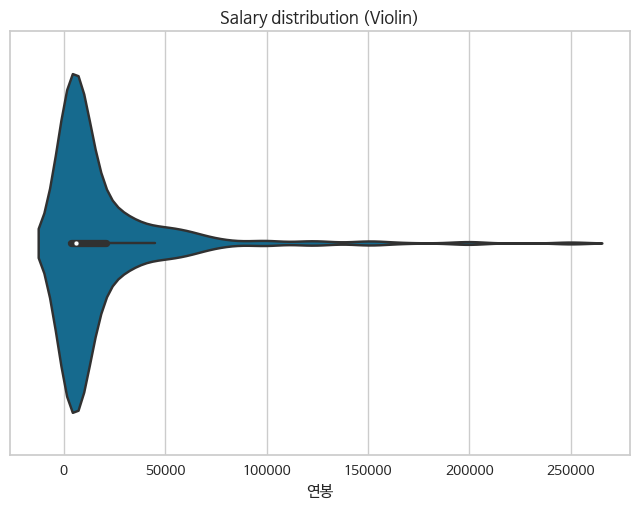

count      1371.000000
mean      19360.765864
std       32299.792920
min        2700.000000
25%        3400.000000
50%        6000.000000
75%       20750.000000
max      250000.000000
Name: 연봉, dtype: float64


In [ ]:
# hitter의 salary 분포 확인
sa = hitter['연봉']
sns.violinplot(x = sa)

plt.title('Salary distribution (Violin)')
plt.show()

print(sa.describe())

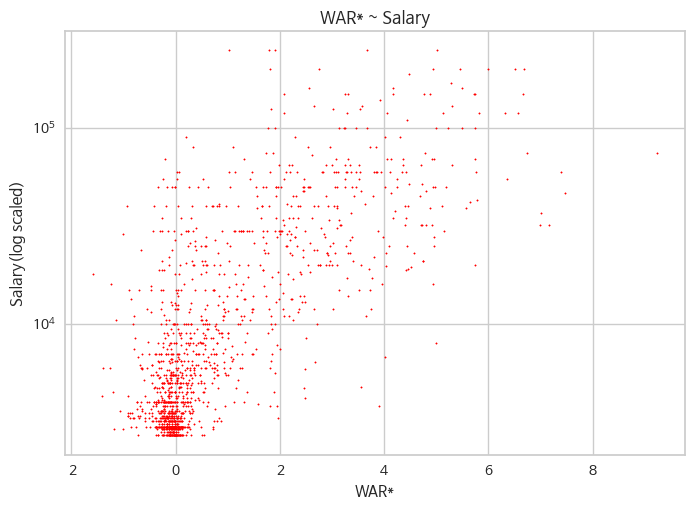

In [ ]:
# hitter의 salary 분포 확인

temp = hitter[['WAR*','연봉']]

plt.scatter(temp['WAR*'], temp.연봉, color = 'red', s = 1)
plt.xlabel('WAR*')
plt.ylabel('Salary(log scaled)')
plt.yscale('log')
plt.title('WAR* ~ Salary')
plt.show()

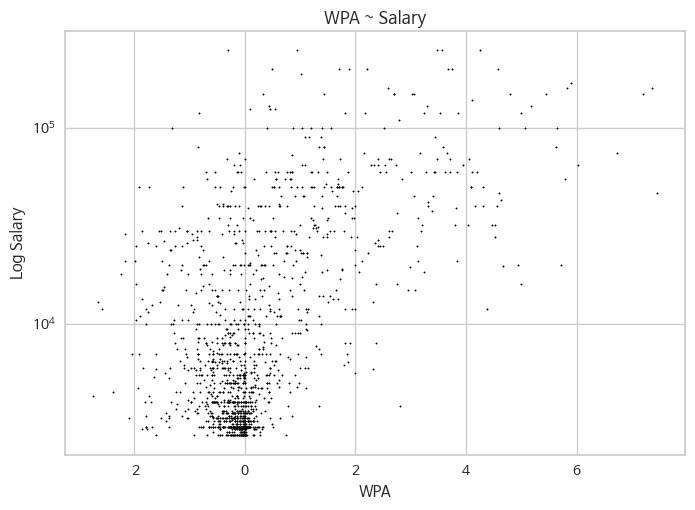

In [ ]:
temp = hitter[['WPA','연봉']]

plt.scatter(temp['WPA'], temp.연봉, color = 'black', s = 1)
plt.xlabel('WPA')
plt.ylabel('Log Salary')
plt.yscale('log')
plt.title('WPA ~ Salary')
plt.show()

WPA와 WAR가 비슷한 형태를 띄고 있습니다. 아마 WAR은 승리기여도이고, WPA는 승리확률기여도를 의미하기 때문이겠죠?

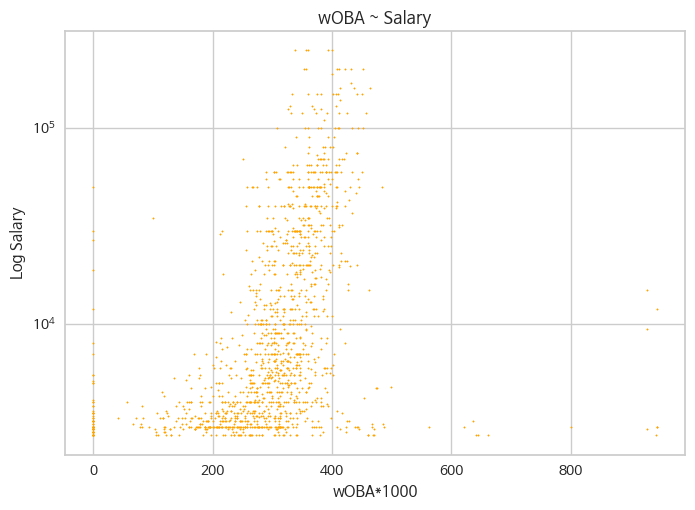

In [ ]:
temp = hitter[['wOBA','연봉']]

plt.scatter([i * 1000 for i in temp['wOBA']], temp.연봉, color = 'orange', s = 1)
plt.xlabel('wOBA*1000')
plt.ylabel('Log Salary')
plt.yscale('log')
plt.title('wOBA ~ Salary')
plt.show()

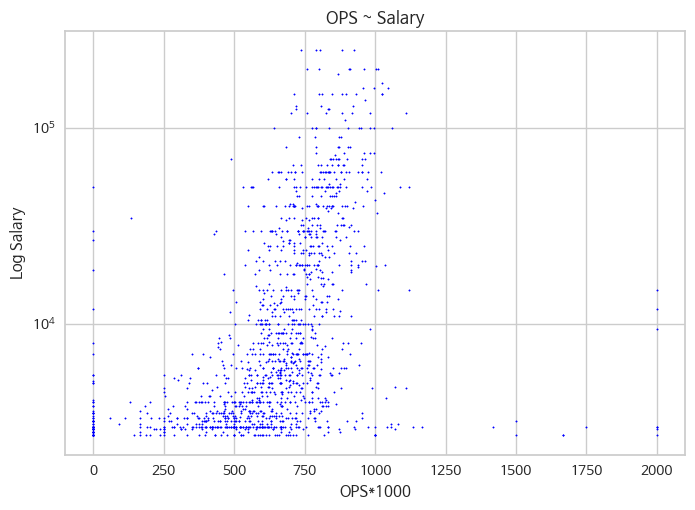

In [ ]:
temp = hitter[['OPS','연봉']]

plt.scatter([i * 1000 for i in temp['OPS']], temp.연봉, color = 'blue', s = 1)
plt.xlabel('OPS*1000')
plt.ylabel('Log Salary')
plt.yscale('log')
plt.title('OPS ~ Salary')
plt.show()

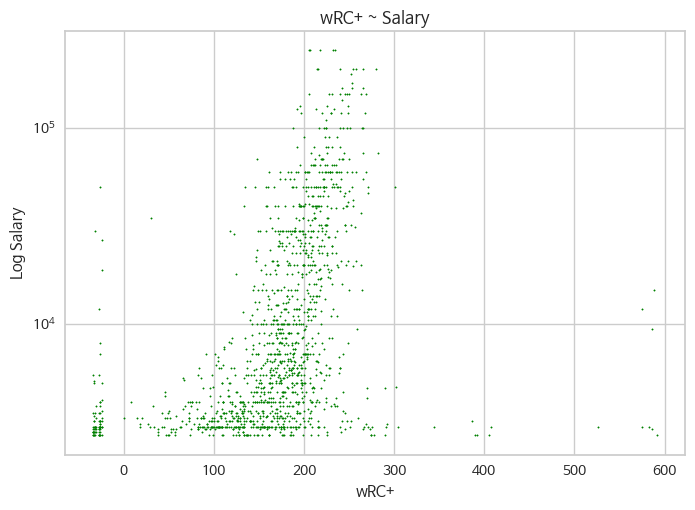

In [ ]:
temp = hitter[['wRC+','연봉']]

plt.scatter([i +100 for i in temp['wRC+']], temp.연봉, color = 'green', s = 1)
plt.xlabel('wRC+')
plt.ylabel('Log Salary')
plt.yscale('log')
plt.title('wRC+ ~ Salary')
plt.show()

wOBA, OPS와 wRC+ 역시 유사한 모습을 보입니다.<br/> 아마 셋다 장타율에 관련된 요소가 작용하는 듯 합니다.

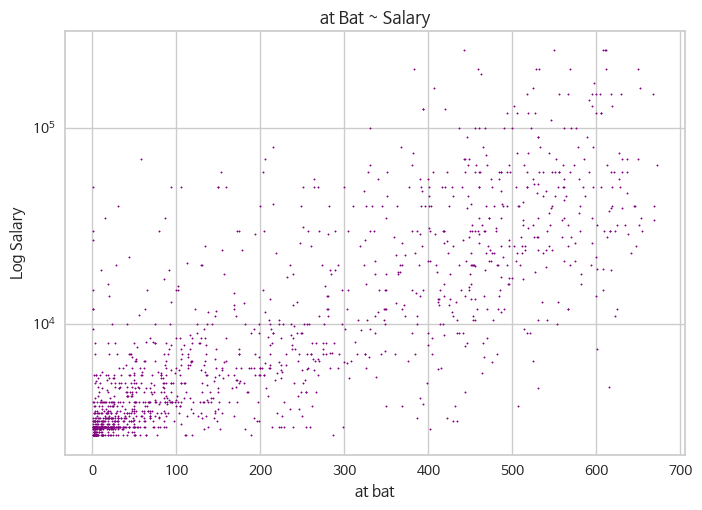

In [ ]:
temp = hitter[['타석','연봉']]

plt.scatter(temp['타석'], temp.연봉, color = 'purple', s = 1)
plt.xlabel('at bat')
plt.ylabel('Log Salary')
plt.yscale('log')
plt.title('at Bat ~ Salary')
plt.show()

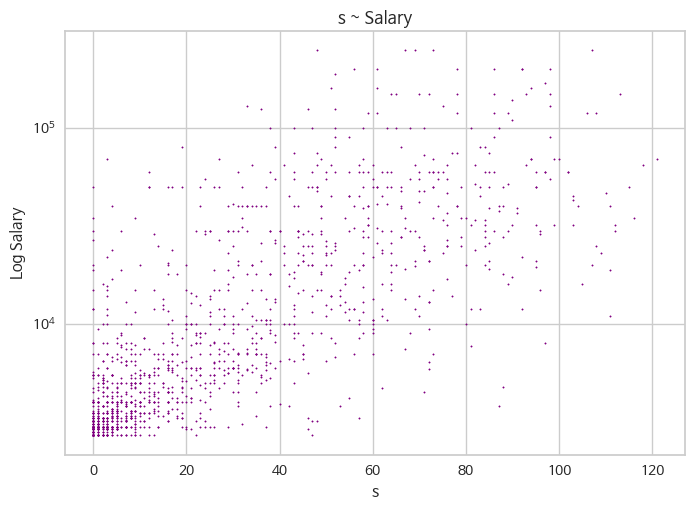

In [ ]:
temp = hitter[['득점','연봉']]

plt.scatter(temp['득점'], temp.연봉, color = 'purple', s = 1)
plt.xlabel('s')
plt.ylabel('Log Salary')
plt.yscale('log')
plt.title('s ~ Salary')
plt.show()

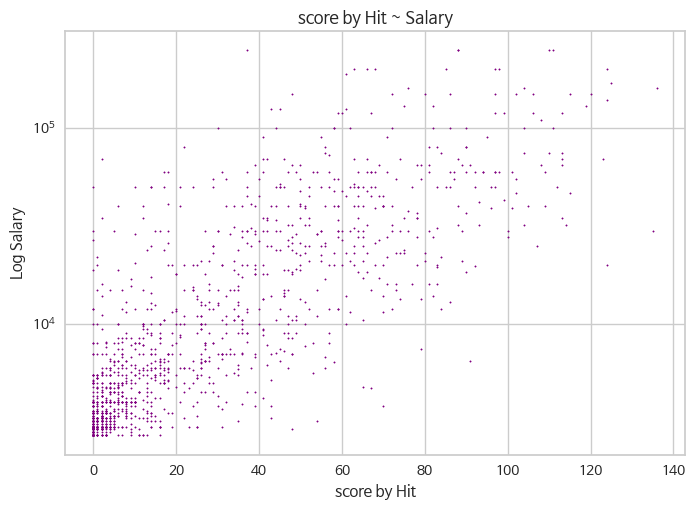

In [ ]:
temp = hitter[['타점','연봉']]

plt.scatter(temp['타점'], temp.연봉, color = 'purple', s = 1)
plt.xlabel('score by Hit')
plt.ylabel('Log Salary')
plt.yscale('log')
plt.title('score by Hit ~ Salary')
plt.show()

득점, 타석, 타점과 연봉의 관계입니다 <br/> 생각보다는 관련이 없어보이긴 하네요

# 연봉~columns 간의 관계 - 투수


In [ ]:
pitcher.columns

Index(['index', '이름', 'WAR', '출장', '완투', '완봉', '선발', '승', '패', '세', '홀드', '이닝',
       '실점', '자책', '타자', '안타', '2타', '3타', '홈런', '볼넷', '고4', '사구', '삼진', '보크',
       '폭투', 'ERA', 'FIP', 'WHIP', 'ERA+', 'FIP+', 'WPA', '소속팀', '연도', '연봉'],
      dtype='object')

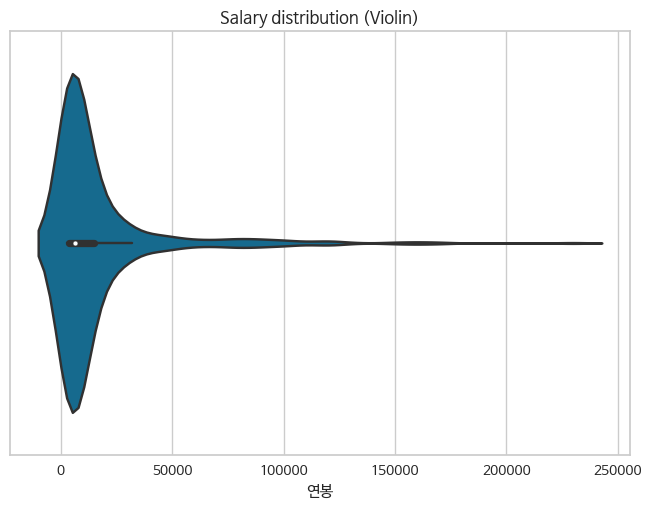

count      1240.000000
mean      16225.216129
std       26809.405907
min        2700.000000
25%        3500.000000
50%        6300.000000
75%       15000.000000
max      230000.000000
Name: 연봉, dtype: float64


In [ ]:
sa = pitcher['연봉']
sns.violinplot(x = sa)

plt.title('Salary distribution (Violin)')
plt.show()

print(sa.describe())

고액 연봉자들과 저액연봉자들의 격차가 큼을 확인 <br/>-> 이를 바탕으로 label 설정하면 될듯!

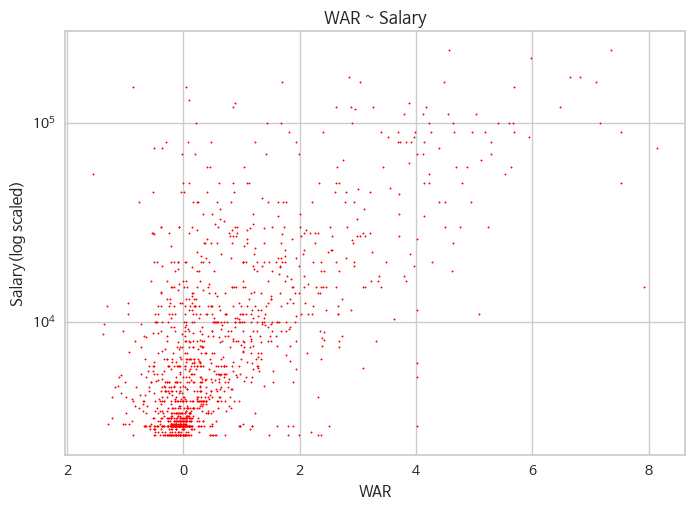

In [ ]:
temp = pitcher[['WAR','연봉']]

plt.scatter(temp['WAR'], temp.연봉, color='red', s = 1)
plt.xlabel('WAR')
plt.ylabel('Salary(log scaled)')
plt.yscale('log')
plt.title('WAR ~ Salary')
plt.show()

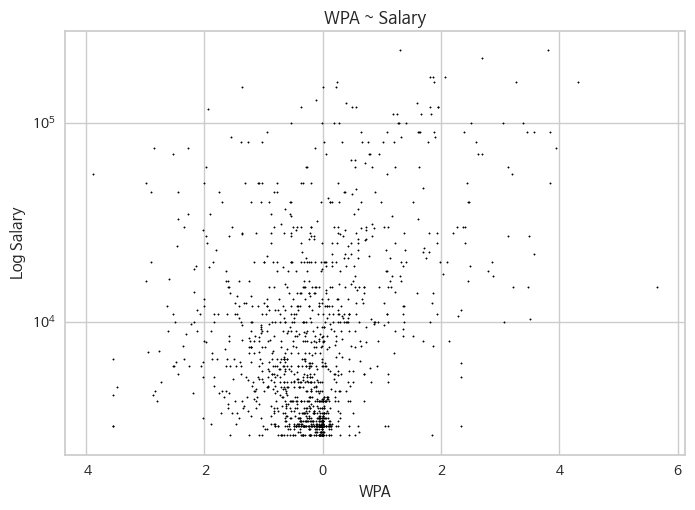

In [ ]:
temp = pitcher[['WPA','연봉']]

plt.scatter(temp['WPA'], temp.연봉, color='black', s = 1)
plt.xlabel('WPA')
plt.ylabel('Log Salary')
plt.yscale('log')
plt.title('WPA ~ Salary')
plt.show()

WPA와 WAR가 비슷한 형태를 띄고 있습니다. 아마 WAR은 승리기여도이고, WPA는 승리확률기여도를 의미하기 때문이겠죠?

# 연봉 데이터 label 넣어주기

In [ ]:
def assign_label(value):
    if value <= q50:
        return 1
    elif value <= q75:
        return 2
    else:
        return 3

q50 = hitter['연봉'].quantile(0.50)
q75 = hitter['연봉'].quantile(0.75)

hitter['label'] = hitter['연봉'].apply(assign_label)
hitter.drop(['연봉'], axis = 1, inplace = True)
hitter['label']

0       3
1       3
2       3
3       3
4       3
       ..
1366    2
1367    1
1368    1
1369    1
1370    2
Name: label, Length: 1371, dtype: int64

In [ ]:
hitter.label.value_counts()

1    695
3    343
2    333
Name: label, dtype: int64

In [ ]:
def assign_label(value):
    if value <= q50:
        return 1
    elif value <= q75:
        return 2
    else:
        return 3

q50 = pitcher['연봉'].quantile(0.50)
q75 = pitcher['연봉'].quantile(0.75)

pitcher['label'] = pitcher['연봉'].apply(assign_label)
pitcher.drop(['연봉'], axis = 1, inplace = True)
pitcher

,index,이름,WAR,출장,완투,완봉,선발,승,패,세,...,폭투,ERA,FIP,WHIP,ERA+,FIP+,WPA,소속팀,연도,label
0,1,양현종,8.14,32,1,1,31,15,6,0,...,6,2.44,4.57,1.24,202.1,108.5,3.94,KIA,2015,3
1,2,안우진,7.92,30,1,0,30,15,8,0,...,7,2.11,2.21,0.95,189.3,179.1,5.65,키움,2022,2
2,3,스트레일리,7.53,31,0,0,31,15,4,0,...,4,2.50,3.01,1.02,195.1,159.0,3.84,롯데,2020,3
3,4,스트레일리,7.53,31,0,0,31,15,4,0,...,4,2.50,3.01,1.02,195.1,159.0,3.84,롯데,2020,3
4,5,양현종,7.35,29,2,2,29,16,8,0,...,1,2.29,2.63,1.07,183.1,160.3,3.81,KIA,2019,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,2045,황동재,-1.29,16,0,0,13,1,3,0,...,1,7.06,4.91,1.84,59.2,84.6,-1.89,삼성,2022,1
1236,2047,김대우,-1.32,25,0,0,7,2,5,0,...,2,9.54,6.48,1.94,53.2,77.7,-2.63,삼성,2017,2
1237,2048,윤대경,-1.37,25,0,0,14,4,9,0,...,5,7.41,3.98,1.63,54.7,102.6,-2.23,한화,2022,2
1238,2049,장시환,-1.38,19,1,0,16,0,11,0,...,7,7.04,4.99,1.96,62.2,89.5,-2.32,한화,2021,2


# RF기준으로 피처 상관관계

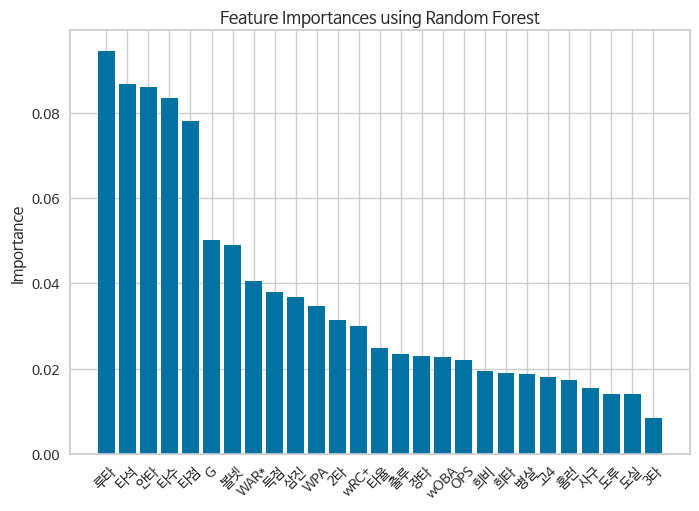

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_hit=hitter.drop(['index','label','이름','소속팀','포지션','연도'], axis = 1)
Y_hit=hitter['label']

feature_names = X_hit.columns

X_hit_train, X_hit_test, Y_hit_train, Y_hit_test = train_test_split(X_hit, Y_hit, test_size = 0.2, random_state = 123)


clf_hit = RandomForestClassifier(n_estimators = 100, random_state = 42)
clf_hit.fit(X_hit_train, Y_hit_train)

importances = clf_hit.feature_importances_
# print(len(importances),len(feature_names))

df_importances_hit = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
df_importances_hit = df_importances_hit.sort_values(by = 'Importance', ascending = False)

plt.bar(df_importances_hit['Feature'], df_importances_hit['Importance'])
plt.ylabel('Importance')
plt.title('Feature Importances using Random Forest')
plt.xticks(rotation = 45)
plt.show()

df_importances_hit.reset_index(drop = True,inplace = True)

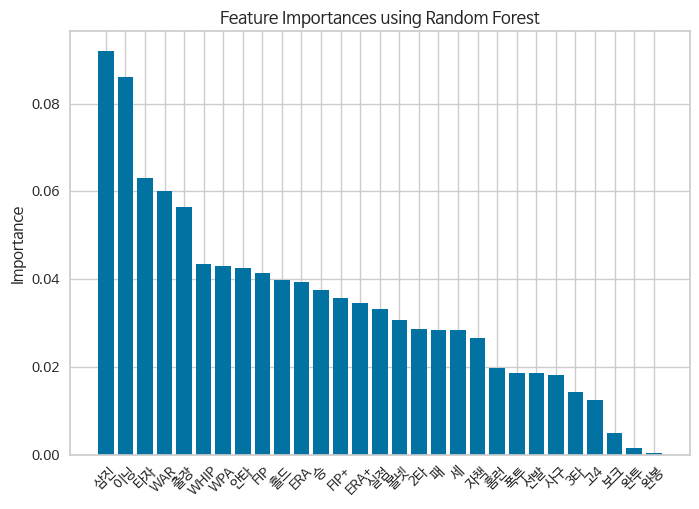

,Feature,Importance
0,삼진,0.091868
1,이닝,0.086056
2,타자,0.063080
3,WAR,0.060142
4,출장,0.056421
5,WHIP,0.043528
6,WPA,0.043060
7,안타,0.042488
8,FIP,0.041378
9,홀드,0.039773


In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_pit=pitcher.drop(['index','label','이름','소속팀','연도'], axis = 1)
Y_pit=pitcher['label']

feature_names = X_pit.columns

X_pit_train, X_pit_test, Y_pit_train, Y_pit_test = train_test_split(X_pit, Y_pit, test_size = 0.2, random_state = 123)

clf_pit = RandomForestClassifier(n_estimators = 100, random_state = 42)
clf_pit.fit(X_pit_train, Y_pit_train)

importances = clf_pit.feature_importances_
# print(len(importances),len(feature_names))

df_importances_pit = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
df_importances_pit = df_importances_pit.sort_values(by = 'Importance', ascending = False)

plt.bar(df_importances_pit['Feature'], df_importances_pit['Importance'])
plt.ylabel('Importance')
plt.title('Feature Importances using Random Forest')
plt.xticks(rotation = 45)
plt.show()

df_importances_pit.reset_index(drop = True, inplace = True)
df_importances_pit[:10]

In [ ]:
print('RF 기준 상위 10개 출력\n 타자의 피처중요도: \n{0}\n\n투수의 피처중요도: \n{1}'.format(df_importances_hit['Feature'][:10],df_importances_pit['Feature'][:10]))

RF 기준 상위 10개 출력
 타자의 피처중요도: 
0      루타
1      타석
2      안타
3      타수
4      타점
5       G
6      볼넷
7    WAR*
8      득점
9      삼진
Name: Feature, dtype: object

투수의 피처중요도: 
0      삼진
1      이닝
2      타자
3     WAR
4      출장
5    WHIP
6     WPA
7      안타
8     FIP
9      홀드
Name: Feature, dtype: object


# 필요한 칼럼끼리 정규화



In [ ]:
hit_columns = df_importances_hit['Feature'][:10].tolist()
pit_columns = df_importances_pit['Feature'][:10].tolist()

hit_columns.append('label')
pit_columns.append('label')

hitter_data = hitter[hit_columns]
pitcher_data = pitcher[pit_columns]

In [ ]:
from sklearn.model_selection import train_test_split

X_hitter = hitter_data.drop(['label'],axis=1)
Y_hitter = hitter['label']
X_hitter_train, X_hitter_test, Y_hitter_train, Y_hitter_test = train_test_split(X_hitter, Y_hitter, test_size = 0.3, random_state = 0)

X_pitcher = pitcher_data.drop(['label'],axis=1)
Y_pitcher = pitcher_data['label']
X_pitcher_train, X_pitcher_test, Y_pitcher_train, Y_pitcher_test = train_test_split(X_pitcher, Y_pitcher, test_size = 0.3, random_state = 0)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

ct_hit = ColumnTransformer([("scaling", StandardScaler(), hit_columns[:-1])])
ct_hit.fit(X_hitter_train)

X_hitter_train = ct_hit.transform(X_hitter_train)
X_hitter_test = ct_hit.transform(X_hitter_test)

ct_pit = ColumnTransformer([("scaling", StandardScaler(), pit_columns[:-1])])
ct_pit.fit(X_pitcher_train)

X_pitcher_train = ct_pit.transform(X_pitcher_train)
X_pitcher_test = ct_pit.transform(X_pitcher_test)

# pycaret - 타자



In [ ]:
from pycaret.classification import *
import numpy as np

exp1 = setup(data = hitter_data, target = 'label')
best_model = compare_models(n_select = 10)

,Description,Value
0,Session id,7512
1,Target,label
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2"
4,Original data shape,"(1371, 11)"
5,Transformed data shape,"(1371, 11)"
6,Transformed train set shape,"(959, 11)"
7,Transformed test set shape,"(412, 11)"
8,Numeric features,10
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7883,0.9135,0.6467,0.7214,0.6780,0.6504,0.6550,2.0080
qda,Quadratic Discriminant Analysis,0.7736,0.9046,0.6596,0.6797,0.6642,0.6332,0.6364,0.0330
lda,Linear Discriminant Analysis,0.7726,0.9052,0.6340,0.7076,0.6667,0.6253,0.6294,0.0750
et,Extra Trees Classifier,0.7695,0.8966,0.6212,0.6892,0.6492,0.6207,0.6253,0.4720
nb,Naive Bayes,0.7664,0.8991,0.6340,0.6732,0.6451,0.6184,0.6230,0.0640
rf,Random Forest Classifier,0.7653,0.9055,0.6297,0.6887,0.6543,0.6156,0.6196,0.7700
ada,Ada Boost Classifier,0.7633,0.8547,0.6003,0.6801,0.6339,0.6083,0.6138,0.1500
knn,K Neighbors Classifier,0.7580,0.8792,0.6044,0.6984,0.6440,0.5999,0.6056,0.1040
lightgbm,Light Gradient Boosting Machine,0.7550,0.8962,0.6273,0.6548,0.6373,0.6016,0.6043,0.5610
ridge,Ridge Classifier,0.7539,0.0000,0.5727,0.6836,0.6173,0.5879,0.5968,0.0710


Processing:   0%|          | 0/74 [00:00<?, ?it/s]

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier

how_many_model = 5
models = []
for mod in best_model[:how_many_model]:
    exec('model = mod')
    models.append((str(model).split('(')[0], model))
print(models)
ensemble_hit = VotingClassifier(models)
ensemble_hit.fit(X_hitter_train, Y_hitter_train)
y_pred = ensemble_hit.predict(X_hitter_train)

[('LogisticRegression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7512, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)), ('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)), ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001)), ('ExtraTreesClassifier', ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
               

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(Y_hitter_train, y_pred)
print(f"Accuracy: {acc:.4f}")

y_test_pred = ensemble_hit.predict(X_hitter_test)
acc_test = accuracy_score(Y_hitter_test, y_test_pred)
print(f"Test Accuracy: {acc_test:.4f}")

Accuracy: 0.7998
Test Accuracy: 0.7743
Accuracy: 0.9937
Test Accuracy: 0.7549


In [ ]:
hit_2023_data = pd.read_csv('2023 hitters.csv')
hit_2023 = hit_2023_data.drop(['순','이름','팀','WAR*.1'], axis = 1)
hit_2023 = ct_hit.transform(hit_2023)

pred_hit_2023 = ensemble_hit.predict(hit_2023)
unique_values, counts = np.unique(pred_hit_2023, return_counts=True)
for value, count in zip(unique_values, counts):
  print(f"{value}: {count}")

hit_2023_data['label'] = pred_hit_2023

1: 173
2: 58
3: 56
1: 175
2: 49
3: 63


In [ ]:
hit_2023_data.to_csv('2023 KBO Salary Prediction - Hitter.csv', index = False)

# pycaret - 투수


In [ ]:
from pycaret.classification import *

exp1 = setup(data = pitcher_data, target = 'label')
best_model = compare_models(n_select=10)

,Description,Value
0,Session id,7836
1,Target,label
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2"
4,Original data shape,"(1240, 11)"
5,Transformed data shape,"(1240, 11)"
6,Transformed train set shape,"(868, 11)"
7,Transformed test set shape,"(372, 11)"
8,Numeric features,10
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6982,0.8354,0.6982,0.6990,0.6932,0.5050,0.5091,0.4480
rf,Random Forest Classifier,0.6981,0.8416,0.6981,0.7022,0.6929,0.5048,0.5097,0.4680
lr,Logistic Regression,0.6912,0.8429,0.6912,0.6861,0.6834,0.4910,0.4959,0.3190
ridge,Ridge Classifier,0.6855,0.0000,0.6855,0.6758,0.6713,0.4738,0.4832,0.0310
lightgbm,Light Gradient Boosting Machine,0.6774,0.8284,0.6774,0.6736,0.6713,0.4719,0.4760,0.8170
gbc,Gradient Boosting Classifier,0.6716,0.8359,0.6716,0.6699,0.6663,0.4624,0.4658,0.6840
lda,Linear Discriminant Analysis,0.6716,0.8398,0.6716,0.6759,0.6682,0.4629,0.4670,0.0340
xgboost,Extreme Gradient Boosting,0.6659,0.8208,0.6659,0.6687,0.6632,0.4567,0.4600,0.3900
nb,Naive Bayes,0.6658,0.8357,0.6658,0.6891,0.6705,0.4681,0.4732,0.0350
qda,Quadratic Discriminant Analysis,0.6579,0.8336,0.6579,0.6948,0.6680,0.4661,0.4727,0.0620


Processing:   0%|          | 0/74 [00:00<?, ?it/s]

,Description,Value
0,Session id,2668
1,Target,label
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2"
4,Original data shape,"(1240, 11)"
5,Transformed data shape,"(1240, 11)"
6,Transformed train set shape,"(868, 11)"
7,Transformed test set shape,"(372, 11)"
8,Numeric features,10
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7039,0.8371,0.6126,0.6555,0.6238,0.5122,0.5169,0.5740
et,Extra Trees Classifier,0.6936,0.8337,0.6080,0.6370,0.6124,0.4973,0.5023,0.4800
gbc,Gradient Boosting Classifier,0.6913,0.8379,0.6020,0.6338,0.6100,0.4957,0.4991,1.6260
lightgbm,Light Gradient Boosting Machine,0.6821,0.8246,0.6034,0.6188,0.6067,0.4802,0.4835,1.5330
xgboost,Extreme Gradient Boosting,0.6741,0.8185,0.5792,0.6090,0.5896,0.4666,0.4693,0.5000
ridge,Ridge Classifier,0.6740,0.0000,0.5570,0.6240,0.5799,0.4548,0.4630,0.0820
lr,Logistic Regression,0.6648,0.8302,0.5606,0.6052,0.5761,0.4467,0.4507,0.6180
lda,Linear Discriminant Analysis,0.6647,0.8313,0.5686,0.6142,0.5803,0.4515,0.4560,0.1550
nb,Naive Bayes,0.6578,0.8239,0.5861,0.6022,0.5780,0.4558,0.4626,0.1290
ada,Ada Boost Classifier,0.6566,0.7743,0.5652,0.5967,0.5724,0.4402,0.4439,0.5930


Processing:   0%|          | 0/74 [00:00<?, ?it/s]

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier

how_many_model = 5
models = []
for mod in best_model[:how_many_model]:
    exec('model = mod')
    models.append((str(model).split('(')[0], model))
print(models)
ensemble_pit = VotingClassifier(models)
ensemble_pit.fit(X_pitcher_train, Y_pitcher_train)
y_pred = ensemble_pit.predict(X_pitcher_train)

[('ExtraTreesClassifier', ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=7836, verbose=0, warm_start=False)), ('RandomForestClassifier', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(Y_pitcher_train, y_pred)
print(f"Accuracy: {acc:.4f}")

y_test_pred = ensemble_pit.predict(X_pitcher_test)
acc_test = accuracy_score(Y_pitcher_test, y_test_pred)
print(f"Test Accuracy: {acc_test:.4f}")

Accuracy: 0.9885
Test Accuracy: 0.7177
Accuracy: 0.9885
Test Accuracy: 0.7339


In [ ]:
pit_2023_data = pd.read_csv('2023 pitchers.csv')
pit_2023 = pit_2023_data.drop(['순','이름','팀','WAR(need to drop)'], axis = 1)
pit_2023 = ct_pit.transform(pit_2023)

pred_pit_2023 = ensemble_pit.predict(pit_2023)
unique_values, counts = np.unique(pred_pit_2023, return_counts = True)
for value, count in zip(unique_values, counts):
  print(f"{value}: {count}")

pit_2023_data['label'] = pred_pit_2023

1: 168
2: 52
3: 50
1: 165
2: 49
3: 56


In [ ]:
pit_2023_data.to_csv('2023 KBO Salary Prediction - Pitcher.csv',index = False)

In [ ]:
hitter

,index,이름,WAR*,G,타석,타수,득점,안타,2타,3타,...,출루,장타,OPS,wOBA,wRC+,WPA,소속팀,연도,포지션,label
0,1,이정후,9.23,142,627,553,85,193,36,10,...,0.421,0.575,0.996,0.441,182.5,6.72,키움,2022,CF,3
1,5,김재환,7.46,144,636,544,110,185,34,2,...,0.429,0.603,1.032,0.440,170.9,7.45,두산,2017,LF,3
2,6,피렐라,7.40,141,630,561,102,192,33,4,...,0.411,0.565,0.976,0.434,169.3,4.20,삼성,2022,LF,3
3,7,김하성,7.17,139,625,540,112,166,38,2,...,0.389,0.491,0.880,0.397,145.7,4.52,키움,2019,SS,3
4,8,박건우,7.01,131,543,483,91,177,40,2,...,0.424,0.582,1.006,0.433,163.8,2.76,두산,2017,CF,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,2244,박종윤,-1.23,98,326,314,29,80,11,3,...,0.277,0.347,0.624,0.279,54.0,-1.97,롯데,2015,1B,2
1367,2245,정범모,-1.25,51,114,96,3,13,2,0,...,0.215,0.156,0.371,0.177,-16.3,-1.10,한화,2015,C,1
1368,2247,강한울,-1.39,90,292,264,30,54,8,3,...,0.250,0.258,0.508,0.229,18.5,-1.36,KIA,2015,SS,1
1369,2248,나종덕,-1.41,104,209,185,12,23,4,0,...,0.188,0.195,0.383,0.180,-4.2,-2.74,롯데,2019,C,1


,index,이름,WAR*,G,타석,타수,득점,안타,2타,3타,...,출루,장타,OPS,wOBA,wRC+,WPA,소속팀,연도,포지션,label
0,1,이정후,9.23,142,627,553,85,193,36,10,...,0.421,0.575,0.996,0.441,182.5,6.72,키움,2022,CF,3
1,5,김재환,7.46,144,636,544,110,185,34,2,...,0.429,0.603,1.032,0.440,170.9,7.45,두산,2017,LF,3
2,6,피렐라,7.40,141,630,561,102,192,33,4,...,0.411,0.565,0.976,0.434,169.3,4.20,삼성,2022,LF,3
3,7,김하성,7.17,139,625,540,112,166,38,2,...,0.389,0.491,0.880,0.397,145.7,4.52,키움,2019,SS,3
4,8,박건우,7.01,131,543,483,91,177,40,2,...,0.424,0.582,1.006,0.433,163.8,2.76,두산,2017,CF,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,2244,박종윤,-1.23,98,326,314,29,80,11,3,...,0.277,0.347,0.624,0.279,54.0,-1.97,롯데,2015,1B,2
1367,2245,정범모,-1.25,51,114,96,3,13,2,0,...,0.215,0.156,0.371,0.177,-16.3,-1.10,한화,2015,C,1
1368,2247,강한울,-1.39,90,292,264,30,54,8,3,...,0.250,0.258,0.508,0.229,18.5,-1.36,KIA,2015,SS,1
1369,2248,나종덕,-1.41,104,209,185,12,23,4,0,...,0.188,0.195,0.383,0.180,-4.2,-2.74,롯데,2019,C,1


In [ ]:
pitcher

,index,이름,WAR,출장,완투,완봉,선발,승,패,세,...,폭투,ERA,FIP,WHIP,ERA+,FIP+,WPA,소속팀,연도,label
0,1,양현종,8.14,32,1,1,31,15,6,0,...,6,2.44,4.57,1.24,202.1,108.5,3.94,KIA,2015,3
1,2,안우진,7.92,30,1,0,30,15,8,0,...,7,2.11,2.21,0.95,189.3,179.1,5.65,키움,2022,2
2,3,스트레일리,7.53,31,0,0,31,15,4,0,...,4,2.50,3.01,1.02,195.1,159.0,3.84,롯데,2020,3
3,4,스트레일리,7.53,31,0,0,31,15,4,0,...,4,2.50,3.01,1.02,195.1,159.0,3.84,롯데,2020,3
4,5,양현종,7.35,29,2,2,29,16,8,0,...,1,2.29,2.63,1.07,183.1,160.3,3.81,KIA,2019,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,2045,황동재,-1.29,16,0,0,13,1,3,0,...,1,7.06,4.91,1.84,59.2,84.6,-1.89,삼성,2022,1
1236,2047,김대우,-1.32,25,0,0,7,2,5,0,...,2,9.54,6.48,1.94,53.2,77.7,-2.63,삼성,2017,2
1237,2048,윤대경,-1.37,25,0,0,14,4,9,0,...,5,7.41,3.98,1.63,54.7,102.6,-2.23,한화,2022,2
1238,2049,장시환,-1.38,19,1,0,16,0,11,0,...,7,7.04,4.99,1.96,62.2,89.5,-2.32,한화,2021,2


,index,이름,WAR,출장,완투,완봉,선발,승,패,세,...,폭투,ERA,FIP,WHIP,ERA+,FIP+,WPA,소속팀,연도,label
0,1,양현종,8.14,32,1,1,31,15,6,0,...,6,2.44,4.57,1.24,202.1,108.5,3.94,KIA,2015,3
1,2,안우진,7.92,30,1,0,30,15,8,0,...,7,2.11,2.21,0.95,189.3,179.1,5.65,키움,2022,2
2,3,스트레일리,7.53,31,0,0,31,15,4,0,...,4,2.50,3.01,1.02,195.1,159.0,3.84,롯데,2020,3
3,4,스트레일리,7.53,31,0,0,31,15,4,0,...,4,2.50,3.01,1.02,195.1,159.0,3.84,롯데,2020,3
4,5,양현종,7.35,29,2,2,29,16,8,0,...,1,2.29,2.63,1.07,183.1,160.3,3.81,KIA,2019,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,2045,황동재,-1.29,16,0,0,13,1,3,0,...,1,7.06,4.91,1.84,59.2,84.6,-1.89,삼성,2022,1
1236,2047,김대우,-1.32,25,0,0,7,2,5,0,...,2,9.54,6.48,1.94,53.2,77.7,-2.63,삼성,2017,2
1237,2048,윤대경,-1.37,25,0,0,14,4,9,0,...,5,7.41,3.98,1.63,54.7,102.6,-2.23,한화,2022,2
1238,2049,장시환,-1.38,19,1,0,16,0,11,0,...,7,7.04,4.99,1.96,62.2,89.5,-2.32,한화,2021,2
